In [2]:
from pydwf import DwfLibrary, DwfAnalogOutNode, DwfAnalogOutFunction
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessary for older matplotlib
from matplotlib import cm
import time
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from scipy.signal import correlate
import pandas as pd
from gmeasure import GMeasure

dwf = DwfLibrary()

In [3]:
def transfer_func(y):
    return (y - 0.03593075008361179)/10.024579938249904

In [1]:
# ============================================================
# Fixed component values
# ============================================================
R1 = 100
L1 = 100e-3
C1 = 0.22e-6

'''R = 1000         # ohms
L = 10e-3        # 10 mH
C = 10e-9        # 10 nF
omega0 = 1/np.sqrt(L*C)   # resonant frequency
f0 = omega0/(2*np.pi)

C_coup_fixed = 1e-9

'''


# Choose a specific C' and C''
Cp  = 1e-6   # C'
Cpp = 1e-6   # C''

# ============================================================
# Impedances
# ============================================================
def Z_R(R): return R
def Z_L(w, L): return 1j*w*L
def Z_C(w, C): return 1/(1j*w*C)

def parallel(a, b):
    return 1/(1/a + 1/b)

# ============================================================
# Gain formula
# ============================================================
def compute_gain(w, Cp, Cpp):
    Z = 1 / ( 1/R1 + 1/Z_L(w, L1) + 1/Z_C(w, C1) )
    Y = parallel(Z, Z + Z_C(w, Cpp))
    G = ( Z/(Z + Z_C(w, Cpp)) ) * ( Y/(Y + Z_C(w, Cp)) )
    return abs(G)



In [5]:
def identity(x):
    return x

def range_finder(signal):
    range_simple = np.ptp(signal)
    return range_simple

In [ ]:
def measure_ac_gain_freq_sweep(
    freq_list, 
    v_in=1, 
    n_meas=5,
    f_f = identity
):
    """
    Measure AC gain across a frequency sweep using repeated GMeasure instances.
    The FIRST sweep point interacts with the user to identify AD2 device order.
    Later points reuse the detected order via prefer_first_device.

    Returns dictionary including means AND standard deviations.
    """

    # --- Output storage (means) ---
    sweep_freqs = []
    sweep_gain = []
    sweep_gain_amp = []
    sweep_vin_range = []
    sweep_vout_range = []
    sweep_vout2_range = []
    sweep_vout2_transfer_range = []

    # --- Output storage (standard deviations) ---
    sweep_gain_std = []
    sweep_gain_amp_std = []
    sweep_vin_std = []
    sweep_vout_std = []
    sweep_vout2_std = []
    sweep_vout2_transfer_std = []

    prefer_bool = None  # <-- updated after first measurement

    for j, f in enumerate(freq_list):

        print(f"\n========== Frequency sweep {j+1}/{len(freq_list)} : {f} Hz ==========\n")

        # --- Step 1: Measurement object ---
        gm = GMeasure(
            osc_channels2=[1, 1],
            osc_channels1=[1, 0],
            out_channels1=[1, 0],
            ad_2=2,
            v_out1=[v_in, 0],
            waveforms_1=["Sine", "DC"],
            supply=[0, 0],
            freq1=[f, 0],
            wavelengths=2,
            prefer_first_device=prefer_bool
        )

        # --- First measurement triggers device-order detection ---
        if j == 0:
            gm.measure2()
            prefer_bool = gm.response
            print(f"\nDevice order detected: prefer_first_device = {prefer_bool}\n")

        # --- Step 2: perform repeated measurements ---
        gains, vin_ranges, vout_ranges, vout2_ranges, vout2_transfer_ranges, gains_amp = [], [], [], [], [], []

        for i in range(n_meas):
            gm.measure2()

            v_1 = np.array(gm.data1[0])
            v_2 = np.array(gm.data2[0])
            v_3 = np.array(gm.data2[1])

            vin_range  = range_finder(v_1)
            vout_range = range_finder(v_2)
            vout2_range = range_finder(v_3)
            vout2_transfer_range = f_f(vout2_range)

            gain     = vout_range / vin_range if vin_range != 0 else np.nan
            gain_amp = f_f(vout2_range) / vin_range if vin_range != 0 else np.nan

            gains.append(gain)
            gains_amp.append(gain_amp)
            vin_ranges.append(vin_range)
            vout_ranges.append(vout_range)
            vout2_ranges.append(vout2_range)
            vout2_transfer_ranges.append(vout2_transfer_range)

        # --- Step 3: store means ---
        sweep_freqs.append(f)
        sweep_gain.append(np.nanmean(gains))
        sweep_gain_amp.append(np.nanmean(gains_amp))
        sweep_vin_range.append(np.nanmean(vin_ranges))
        sweep_vout_range.append(np.nanmean(vout_ranges))
        sweep_vout2_range.append(np.nanmean(vout2_ranges))
        sweep_vout2_transfer_range.append(np.nanmean(vout2_transfer_ranges))

        # --- Step 4: store standard deviations ---
        sweep_gain_std.append(np.nanstd(gains))
        sweep_gain_amp_std.append(np.nanstd(gains_amp))
        sweep_vin_std.append(np.nanstd(vin_ranges))
        sweep_vout_std.append(np.nanstd(vout_ranges))
        sweep_vout2_std.append(np.nanstd(vout2_ranges))
        sweep_vout2_transfer_std.append(np.nanstd(vout2_transfer_ranges))

        print(
            f"Freq {f} Hz → Gain = {np.nanmean(gains):.3f} ± {np.nanstd(gains):.3f}, "
            f"Gain Amp = {np.nanmean(gains_amp):.3f} ± {np.nanstd(gains_amp):.3f}"
        )

    # --- Return summary ---
    return {
        "freq": sweep_freqs,
        "gain": sweep_gain,
        "gain_std": sweep_gain_std,
        "gain_amp": sweep_gain_amp,
        "gain_amp_std": sweep_gain_amp_std,
        "vin_range": sweep_vin_range,
        "vin_std": sweep_vin_std,
        "vout_range": sweep_vout_range,
        "vout_std": sweep_vout_std,
        "vout2_range": sweep_vout2_range,
        "vout2_std": sweep_vout2_std,
        "vout2_transfer_range": sweep_vout2_transfer_range,
        "vout2_transfer_std": sweep_vout2_transfer_std,
        "device_preference": prefer_bool
    }

def figures2(data, gain):
    plt.rcParams['font.family'] = "STIXGeneral"
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 8), sharex=True)
    
    
    def style_axis(ax):
        for side in ['top', 'bottom', 'left', 'right']:
            ax.spines[side].set_color('black')
            ax.spines[side].set_linewidth(0.8)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
        ax.xaxis.set_minor_locator(AutoMinorLocator(3))

    # Gain plot (top)
    style_axis(ax1)
    ax1.set_xlim(1e2, 1e5)
    f_theoretical = np.logspace(2,5,10000)
    ax1.plot(f_theoretical, gain(2*np.pi*f_theoretical,0.033e-6,0.033e-6), "--k",color = "grey", alpha = 0.8, zorder=0)
    ax1.errorbar(data["freq"], data["gain"], yerr=data["gain_std"], fmt='o',
                 c="black", ecolor="grey", elinewidth=1, capsize=3,
                 markersize=4, alpha=0.7, label="Gain (dB)", zorder=0)
    
    ax1.set_ylabel("Gain", fontsize=20)
    ax1.set_xlabel("Frequency (Hz)", fontsize=20)
    ax1.set_xscale("log")
    ax1.tick_params(axis='both', which='major', labelsize=15)
    plt.savefig(" Frequency_Gain_3.pdf")

In [6]:
def make_cv(name, n, cv_bool = True):
    freq = np.logspace(2,5, 100)
    freq_gain_storage = measure_ac_gain_freq_sweep(freq_list=freq, v_in=1, n_meas= n, f_f = transfer_func)
    data = pd.DataFrame(freq_gain_storage)
    if cv_bool:
        data.to_csv(name)
    figures2(data=freq_gain_storage, gain=compute_gain)


========== Frequency sweep 1/100 : 100.0 Hz ==========

Detected Devices:
  Device 0: Serial 210321AA27B7
  Device 1: Serial 210321B5D70C
→ Device 1: 210321AA27B7 | Device 2: 210321B5D70C
DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.

Device order detected: prefer_first_device = True

DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.
DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.
DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.
DwfAnalogOutMode.Voltage
Collected 8192 samples from active channels in out_channels1.
Collected 8192 samples from active channels in out_channels2.
DwfAnalogOutMo

/tmp/ipykernel_1323/897912654.py:139: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(f_theoretical, gain(2*np.pi*f_theoretical,0.068e-6,0.068e-6), "--k",color = "grey", alpha = 0.8, zorder=0)


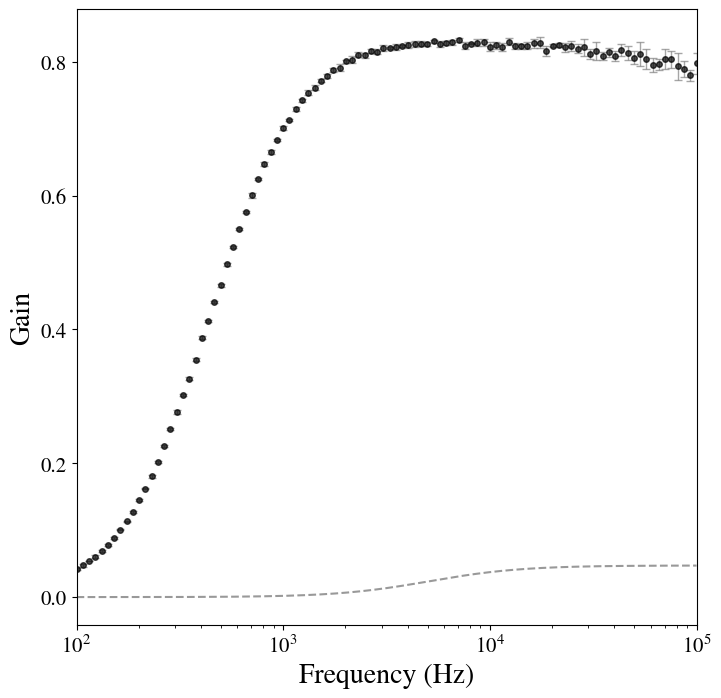

In [30]:
make_cv("4.7uF_frequency_sweep_n5.csv", 5)

In [7]:
def figures2_all(data_list, labels, gain):
    plt.rcParams['font.family'] = "STIXGeneral"
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 8), sharex=True)
    
    def style_axis(ax):
        for side in ['top', 'bottom', 'left', 'right']:
            ax.spines[side].set_color('black')
            ax.spines[side].set_linewidth(0.8)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
        ax.xaxis.set_minor_locator(AutoMinorLocator(3))

    # Style
    style_axis(ax1)
    ax1.set_xlim(1e2, 1e5)

    # Theoretical curve (same as yours)
    f_theoretical = np.logspace(2, 5, 10000)
    ax1.plot(
        f_theoretical,
        gain(2*np.pi*f_theoretical, 0.047e-6, 0.047e-6),
        "--k", color="grey", alpha=0.8, zorder=0
    )

    # Plot all datasets on the same axes
    for data, label in zip(data_list, labels):
        ax1.errorbar(
            data["freq"], data["gain"], yerr=data["gain_std"],
            fmt='o', c="black", ecolor="grey", elinewidth=1,
            capsize=3, markersize=4, alpha=0.7,
            label=label, zorder=0
        )

    # Labels and scales
    ax1.set_ylabel("Gain", fontsize=20)
    ax1.set_xlabel("Frequency (Hz)", fontsize=20)
    ax1.set_xscale("log")
    ax1.tick_params(axis='both', which='major', labelsize=15)

    ax1.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig("Frequency_Gain_All.pdf")
    plt.show()


In [8]:
df1 = pd.read_csv("1uF_frequency_sweep_n10.csv")
df0_22 = pd.read_csv("0.22uF_frequency_sweep_n5.csv")
df0_1 = pd.read_csv("0.1uF_frequency_sweep_n5.csv")
df0_068 = pd.read_csv("0.068uF_frequency_sweep_n5.csv")
df0_047 = pd.read_csv("0.047uF_frequency_sweep_n5.csv")
df0_033 = pd.read_csv("0.033uF_frequency_sweep_n5.csv")
df10 = pd.read_csv("10uF_frequency_sweep_n5.csv")
df4_7 = pd.read_csv("4.7uF_frequency_sweep_n5.csv")

In [9]:
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

def figures2_all(data_list, labels, gain, switch = 1000, name = "figure.pdf"):
    plt.rcParams['font.family'] = "STIXGeneral"
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 8), sharex=True)

    SWITCH_FREQ = switch # Hz

    def style_axis(ax):
        for side in ['top', 'bottom', 'left', 'right']:
            ax.spines[side].set_color('black')
            ax.spines[side].set_linewidth(0.8)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
        ax.xaxis.set_minor_locator(AutoMinorLocator(3))

    style_axis(ax1)
    ax1.set_xlim(1e2, 1e5)
    ax1.set_xscale("log")

    # Frequency axis for theory
    f_theoretical = np.logspace(2, 5, 10000)

    # -----------------------------
    # Plot theory + data
    # -----------------------------

    
    for data, label in zip(data_list, labels):

        # ---- Extract capacitance from label ----
        # e.g. "4.7uF", "0.047 µF"
        data = data[0:99]
        C_uF = float(label.replace("µF", "").replace("uF", "").strip())
        C = C_uF * 1e-6  # convert to Farads

        # ---- Theoretical curve ----
        ax1.plot(
            f_theoretical,
            gain(2*np.pi*f_theoretical, C, C),
            "--",
            color="grey",
            alpha=0.8,
            zorder=0
        )

        
        # ---- Hybrid experimental gain ----
        
        if C_uF<0.5:
            freq = data["freq"]
            gain_combined = np.where(
                freq < 100000,
                data["gain_amp"],
                data["gain"]
            )
        else:
            freq = data["freq"]
            gain_combined = np.where(
            freq < SWITCH_FREQ,
            data["gain_amp"],
            data["gain"]
            )

        ax1.errorbar(
            freq,
            gain_combined,
            yerr=data["gain_std"],
            fmt='o',
            c="black",
            ecolor="grey",
            elinewidth=1,
            capsize=3,
            markersize=4,
            alpha=0.7,
            label=label
        )

    # -----------------------------
    # Vertical switch line
    # -----------------------------


    # Labels
    ax1.set_ylabel("Gain", fontsize=28)
    ax1.set_xlabel("Frequency (Hz)", fontsize=28)
    ax1.tick_params(axis='both', which='major', labelsize=22)

    plt.tight_layout()
    plt.savefig(name)
    plt.show()

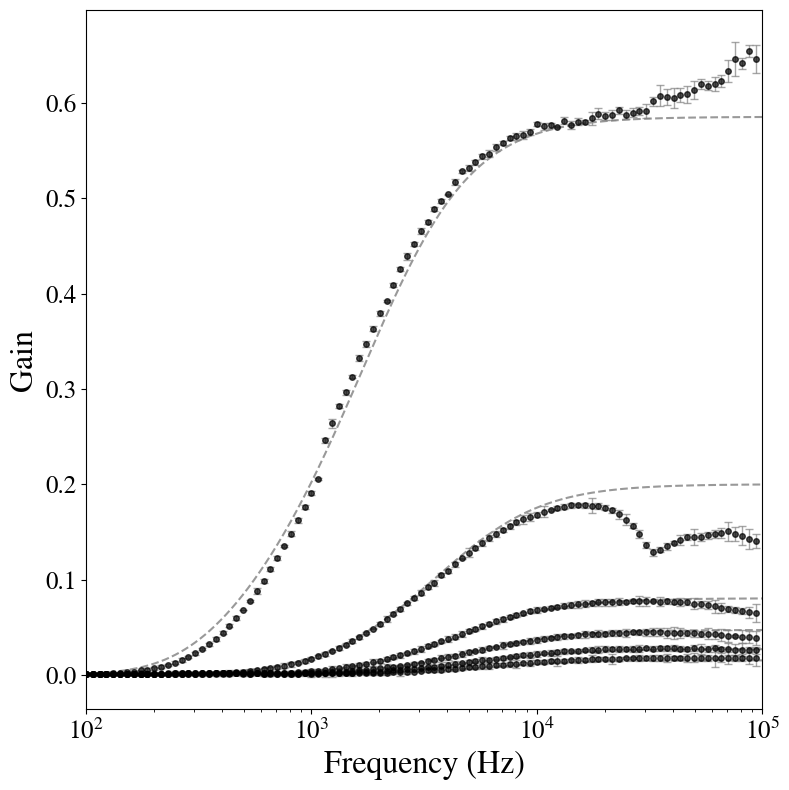

In [22]:
data_list = [ df1, df0_22, df0_1, df0_068, df0_047, df0_033]
labels = ["1 µF", "0.22 µF", "0.1 µF", "0.068 µF", "0.047 µF","0.033"]

figures2_all(data_list, labels, compute_gain, switch=1100)

In [10]:
def transfer_func(y):
    return (y - 0.03593075008361179) / 10.024579938249904


def rebuild_dataframe(
    df,
    fit_start=11,
    fit_end=67,
    freq_threshold=1000
):
    """
    Create a new DataFrame with corrected vout2_range values,
    keeping original values below a frequency threshold.
    """

    # -------------------------------------------------
    # 1. Fit linear relation in the reliable region
    # -------------------------------------------------
    fit_df = df.iloc[fit_start:fit_end + 1]

    x = fit_df["vout_range"].values
    y = fit_df["vout2_range"].values

    a, b = np.polyfit(x, y, 1)

    # -------------------------------------------------
    # 2. Copy DataFrame
    # -------------------------------------------------
    new_df = df.copy()

    # -------------------------------------------------
    # 3. Conditionally update vout2_range
    # -------------------------------------------------
    model_vout2 = a * new_df["vout_range"] + b

    mask_high_freq = new_df["freq"] > freq_threshold

    new_df.loc[mask_high_freq, "vout2_range"] = model_vout2[mask_high_freq]

    # -------------------------------------------------
    # 4. Recompute vout2_transfer_range
    # -------------------------------------------------
    new_df["vout2_transfer_range"] = transfer_func(
        new_df["vout2_range"]
    )

    # -------------------------------------------------
    # 5. Recompute gain_amp
    # -------------------------------------------------
    new_df["gain_amp"] = (
        new_df["vout2_transfer_range"] / new_df["vin_range"]
    )

    return new_df


In [11]:
df_new_0_22 = rebuild_dataframe(df0_22)

In [12]:
df_new_1 = rebuild_dataframe(df1)

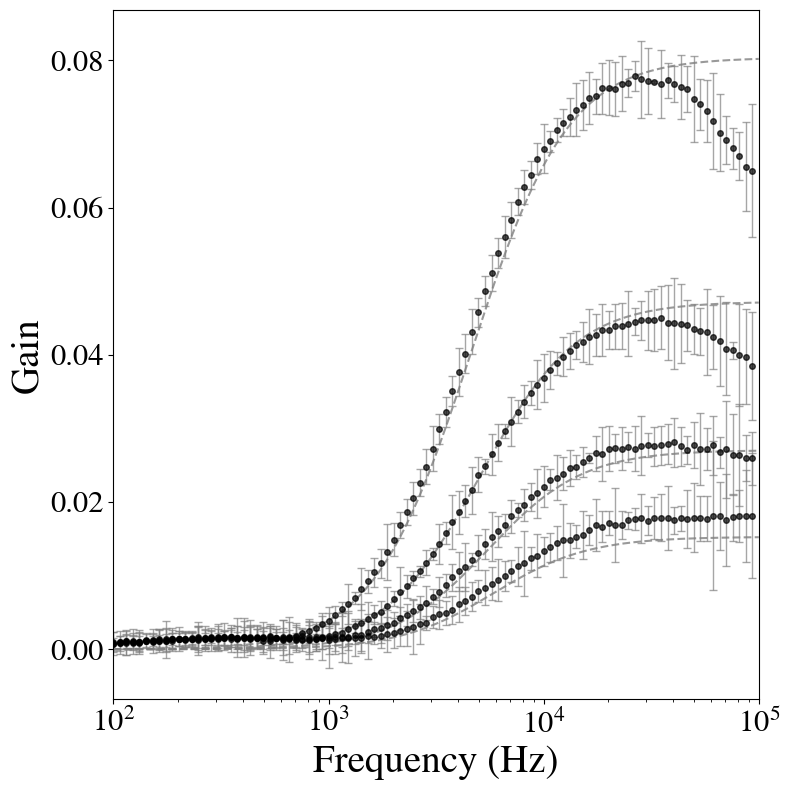

In [13]:
data_list = [ df0_1, df0_068, df0_047, df0_033]
labels = ["0.1 µF", "0.068 µF", "0.047 µF","0.033"]

figures2_all(data_list, labels, compute_gain, switch=0, name ="Frequency_Gain_Side_B.pdf")

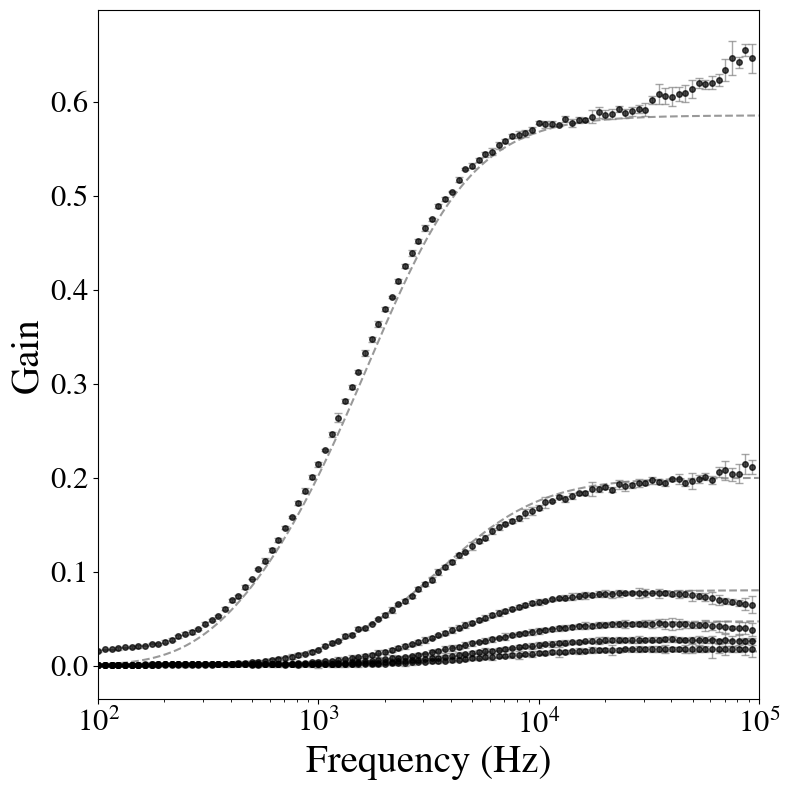

In [14]:
data_list = [ df_new_1, df_new_0_22, df0_1, df0_068, df0_047, df0_033]
labels = ["1 µF", "0.22 µF", "0.1 µF", "0.068 µF", "0.047 µF","0.033"]

figures2_all(data_list, labels, compute_gain, switch=0, name =  "Frequency_Gain_Side_A.pdf")

In [105]:
def r2_all(data_list, labels, gain, switch=1000):
    """
    Compute R^2 values between experimental hybrid gain
    and theoretical gain curves for each dataset.

    Returns
    -------
    r2_dict : dict
        {label : R^2 value}
    """

    SWITCH_FREQ = switch  # Hz
    r2_dict = {}

    for data, label in zip(data_list, labels):

        # ---- Match plotting behavior ----
        data = data[0:99]

        # ---- Extract capacitance from label ----
        C_uF = float(label.replace("µF", "").replace("uF", "").strip())
        C = C_uF * 1e-6  # Farads

        freq = data["freq"]

        # ---- Hybrid experimental gain (same logic as plot) ----
        if C_uF < 0.5:
            gain_exp = np.where(
                freq < 100000,
                data["gain_amp"],
                data["gain"]
            )
        else:
            gain_exp = np.where(
                freq < SWITCH_FREQ,
                data["gain_amp"],
                data["gain"]
            )

        # ---- Theoretical gain evaluated at experimental frequencies ----
        gain_theory = gain(2*np.pi*freq, C, C)

        # ---- R^2 calculation ----
        residuals = gain_exp - gain_theory
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((gain_exp - np.mean(gain_exp))**2)

        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        r2_dict[label] = r2

    return r2_dict


In [106]:
data_list = [ df_new_1, df_new_0_22, df0_1, df0_068, df0_047, df0_033]
labels = ["1 µF", "0.22 µF", "0.1 µF", "0.068 µF", "0.047 µF","0.033"]
r2_all(data_list, labels, compute_gain)

{'1 µF': np.float64(0.9937345584690386),
 '0.22 µF': np.float64(0.997816762525045),
 '0.1 µF': np.float64(0.9866574333663178),
 '0.068 µF': np.float64(0.9874782204028554),
 '0.047 µF': np.float64(0.989196419165466),
 '0.033': np.float64(0.9265593113020518)}